# Modèles basés sur des arbres en classifieurs faibles
   Pas de méthode de recalibrage utilisée.

   Objectif : comparer les performances des mêmes modèles, avec et sans recalibrage Borderline SMOTE.

**(1) Importation des librairies**

In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys 
import fastparquet
import dask_ml 
from dask import delayed
from sklearn.metrics import *
import scikitplot as skplt
from dask_ml.preprocessing import StandardScaler
import pickle

**(2) Import des algorithmes random forest, adaboost, Extrème Gradient Boosting**

**random forest** :  plusieurs arbres sont créés et chaque arbre est formé sur un échantillon du jeu d’entraînement avec bagging.

**adaboost** : avantages (1) simple d'utilisation (2) convergence de l'erreur d'entraînement / faible risque de sur-apprentissage. Principe : repose sur la sélection itérative du classifieur faible (un arbre) en fonction d'une distribution des exemples d'apprentissage. Chaque exemple est pondéré en fonction de sa difficulté avec le classifieur courant.

**XGBoost(extreme gradient boosting)** : Cette méthode repose sur les arbres de décision et s'améliore à partir d'autres méthodes telles que la forêt aléatoire. Elle est efficace avec les jeux de données volumineux et complexes en faisant appel à diverses méthodes d'optimisation. 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

import dask
import dask
import xgboost
import dask_xgboost

C:\Users\chrys\anaconda3\lib\site-packages\dask_xgboost\__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(


In [3]:
#pip install dask.ml

In [4]:
#pip install scikit-plot

# I. Préparation

**(1) variables explicatives, variable à prédire et centrage-réduction**

In [5]:
import os
os.chdir("C:/Fouille-donnees-massives")

In [6]:
# Dataframe d’apprentissage sans recalibrage
df_train = dd.read_parquet("train_fast")
df_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, FlagImpaye to CA3TR
dtypes: float64(7), int64(5)

In [7]:
# Dataframe de test
df_test = dd.read_parquet("test_fast")
df_test.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
3899362,0,60.00,0,302,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00
3899363,0,25.00,0,547,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00
3899364,0,32.00,0,152,0.000000,0.000000,0.000000,52.076034,0,1,4.000000,0.00
3899365,0,20.88,0,393,0.007590,0.182221,0.002092,34.118277,4,1,1.539155,71.51
3899366,0,20.21,0,152,0.018994,-1.024399,0.005682,52.076034,0,1,4.000000,0.00


In [8]:
# Définir les variables explicatives et la variable cible 
X_train = df_train.drop(["FlagImpaye"], axis = "columns")
X_test = df_test.drop(["FlagImpaye"], axis = "columns")

y_train = df_train["FlagImpaye"]
y_test = df_test["FlagImpaye"]

In [9]:
X_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, Montant to CA3TR
dtypes: float64(7), int64(4)

In [10]:
# Instanciation de StandardScaler pour centrer-réduire les données
scaler = StandardScaler()

In [11]:
# Centrer-réduire le dataframe d'apprentissage
X_train = scaler.fit_transform(X_train)
X_train.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,-0.420302,-0.581824,1.017656,-0.084590,-0.239505,-0.275801,0.818043,-0.043817,-0.194165,-0.451325,-0.202861
1,-0.420302,-0.581824,1.017656,-0.084590,-0.239505,-0.275801,0.818043,-0.043812,4.975724,-0.451325,0.038808
2,-0.022127,-0.581824,1.008573,-0.084590,-0.239505,-0.275801,0.818043,-0.043817,-0.194165,-0.451325,-0.202861
3,-0.057565,1.545332,-0.272152,-0.084590,-0.239505,-0.275801,0.906727,-0.043817,-0.194165,-0.451325,-0.202861
4,-0.347310,-0.581824,1.008573,-0.084434,0.637044,-0.273204,0.818043,-0.043812,-0.194165,-0.451325,0.702346


In [12]:
# Centrer-réduire les dataframe de test
X_test = scaler.fit_transform(X_test)
X_test.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
3899362,-0.016999,0.0,0.265719,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257
3899363,-0.277531,0.0,1.427785,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257
3899364,-0.225425,0.0,-0.445750,-0.080269,-0.043960,-0.317899,0.774799,-0.036921,-0.18432,-0.568544,-0.132257
3899365,-0.308200,0.0,0.697344,-0.080074,-0.023966,-0.314458,-0.277090,-0.036897,-0.18432,-5.906429,1.259186
3899366,-0.313187,0.0,-0.445750,-0.079781,-0.156360,-0.308551,0.774799,-0.036921,-0.18432,-0.568544,-0.132257


**(2) Maximisation de la marge**

In [13]:
def perte(Montant):
    if Montant<=20:
        Montant=Montant*0
    elif 20<Montant<=50:
        Montant=0.2*Montant
    elif 50<Montant<=100:
        Montant=0.3*Montant
    elif 100<Montant<=200:
        Montant=0.5*Montant
    elif Montant>200:
        Montant=0.8*Montant
    return(Montant)

In [14]:
def Calcul_Marge(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable Marge
    # Création d'une colonne Marge égale au Montant
    dfmerge["Marge"] = dfmerge["Montant"]
    #Calcul du gain ou de la perte selon la différence entre réel et prédiction
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "Marge"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "Marge"] = 0.7 * 0.05 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "Marge"] = dfmerge["Montant"].apply(lambda x: -perte(x))
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 0)), "Marge"] = 0.05 * dfmerge["Montant"]
    
    # Calcul du Marge_totale
    Marge_totale = dfmerge["Marge"].sum()
    
    return Marge_totale

**(3) Modèles et performances**

In [15]:
# Fonction de déploiement d'un modèle sur les données de test

# Création de la fonction de performance d'un modèle sur les données de test

def performances(modele, X_test, y_test, scale):
    
    X_test_ = X_test
    
    print("-------------------------------------------------------")
   
    
    if scale == True:
        X_test = scaler.transform(X_test) # scaler a été entrainé sur les données d'apprentissage
        
    # Affichage du modèle 
    print('Modèle :\n', modele)
    print("-------------------------------------------------------")
    # Prédiction
    y_pred = delayed(modele.predict)(X_test).compute()
    # Prédiction des scores
    y_score = delayed(modele.predict_proba)(X_test).compute()
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(y_test, y_pred).compute()
    cr = delayed(classification_report)(y_test, y_pred).compute()
    auc = delayed(roc_auc_score)(y_test, y_pred).compute()
    f1 = delayed(f1_score)(y_test, y_pred).compute()
   
    print('F1_score :\n', f1)
    print("-------------------------------------------------------")
    print('Estimateurs :\n', cr)
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm)
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc)
    print("-------------------------------------------------------")
    
    #Calcul de la Marge
    Marge_totale = Calcul_Marge(Montant = X_test_["Montant"].compute(), yReel = y_test.compute(), yPred = y_pred)
    print("Marge = " + str(round(Marge_totale, 2)) + " euros")
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(y_test, y_score, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(y_test, y_score, classes_to_plot = 1, plot_micro = False)

    #return y_score,Marge_totale,auc,cr,cm

Si la courbe ROC tient la route avec un critère AUC élevé, cela signifie que l'apprentissage a bien fonctionné Si le F1_score est très mauvais, cela signifie alors que c'est le processus d'affectation qui n'a pas fonctionné.

# III. Algorithmes

# A. Random forest

GridSearch n'a pu être implémenté en raison des temps de traitement (tentative : pas de sortie au bout de 5h).

In [16]:
#Instanciation # 10 arbres #critère d'évaluation : indice de Gini (log_loss) # nb_mini_individus dans 1 feuille : 10
#Bootstrap = True (par défaut) #random_state= 0 déjà testé - 42 : le plus souvent utilisé avec "0"

RandomForest = RandomForestClassifier(n_estimators = 10, random_state = 0, min_samples_leaf = 10,min_samples_split=3)

# Fit your pipeline onto your training set (centré-réduit) and obtain predictions by fitting the model onto the test data
%time classifier1 = delayed(RandomForest.fit)(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


-------------------------------------------------------
Modèle :
 Delayed('fit-749cf155-ca56-4336-b9d4-04269827d9f9')
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 6min 24s
Wall time: 6min 23s


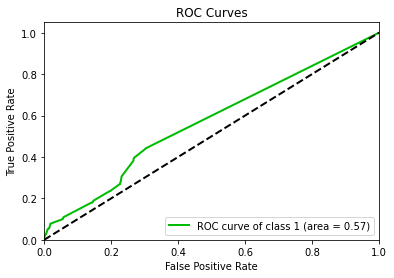

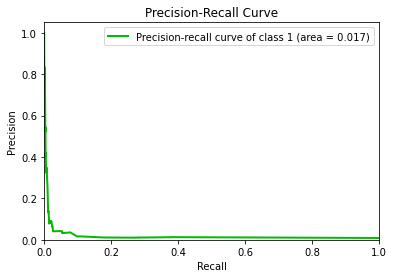

In [17]:
%time performances(classifier1, X_test, y_test,scale=True)

In [18]:
#dir(RandomForest)

**Différences avec le même modèle avec BorderlineSMOTE :**

-Montant en caractéristique principale du modèle (vs Taux chèques impayés)

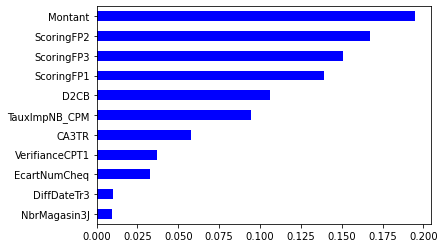

In [19]:
importances = pd.Series(RandomForest.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

**(1) Le modèle n'est pas très bon (marge) = -98.31€ -> Tuning : on teste le bagging pour réduire l'instabilité**

In [20]:
from sklearn.ensemble import BaggingClassifier
#from sklearn.model_selection import GridSearchCV # annulé pour cause de durée de traitement

In [21]:
#avec bagging 
model_best= RandomForestClassifier(n_estimators = 10, random_state = 0, min_samples_leaf = 10,min_samples_split=3)

modele_best =BaggingClassifier(base_estimator=model_best,n_estimators = 10, random_state = 0,n_jobs=-1)

In [22]:
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifierb = delayed(model_best.fit)(X_train, y_train).compute()

CPU times: total: 3min 9s
Wall time: 3min 8s


-------------------------------------------------------
Modèle :
 RandomForestClassifier(min_samples_leaf=10, min_samples_split=3,
                       n_estimators=10, random_state=0)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 6.36 s
Wall time: 5.64 s


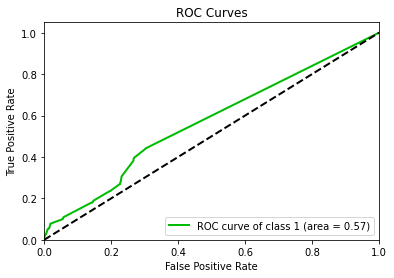

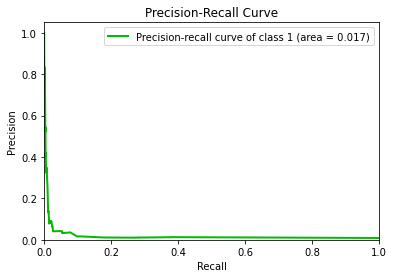

In [23]:
%time performances(classifierb, X_test, y_test,scale=True)

**Pas de différence avec et sans bagging**

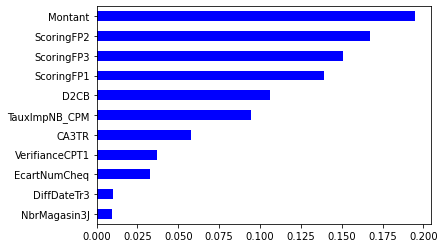

In [24]:
importances = pd.Series(model_best.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# B. Adaboost

Le modèle est moins bon sans qu'avec BorderlineSMOTE.

In [25]:
# Instanciation avec les mêmes paramètres
dtree = DecisionTreeClassifier(random_state = 0, min_samples_leaf = 10,min_samples_split=3, max_depth = 2)

AdaBoost = AdaBoostClassifier(base_estimator = dtree, random_state = 0, n_estimators = 10)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier4 = delayed(AdaBoost.fit)(X_train, y_train).compute()

CPU times: total: 1min 59s
Wall time: 1min 58s


In [26]:
classifier4

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=10,
                                                         min_samples_split=3,
                                                         random_state=0),
                   n_estimators=10, random_state=0)

-------------------------------------------------------
Modèle :
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=10,
                                                         min_samples_split=3,
                                                         random_state=0),
                   n_estimators=10, random_state=0)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 7.33 s
Wall time: 6.62 s


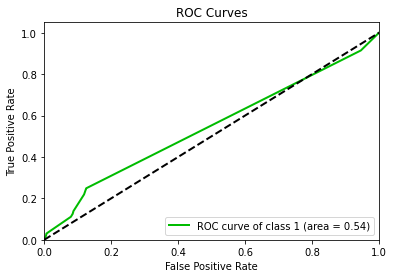

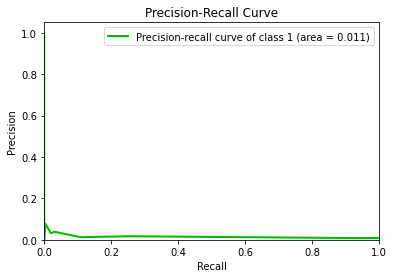

In [27]:
%time performances(classifier4, X_test, y_test,scale=True)

**Différences avec la même modèle sans BorderlineSMOTE :**

-3 variables importantes vs 1 (Scoring P2 +FP1+VerifianceCPT1) vs Scoring FP2

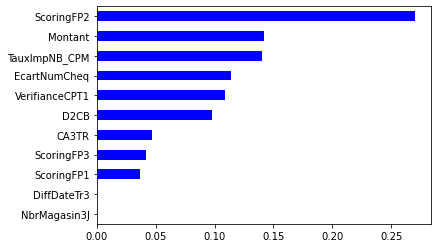

In [28]:
importances = pd.Series(AdaBoost.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

# C. XGradient boosting

XGBoost paraît etre le meilleur modèle de cette famille, parmi les 3 testés. Un arbre peu profond, suffit à générer en tendance les meilleurs résultats avec un recalibrage préalable BorderlineSMOTE. 

Sans recalibrage, en revanche, la modèle obtient de moins bonnes performances. 

In [29]:
# En pratique, ces arbres sont peu profonds, nous conservons max_depth=2

from xgboost import XGBClassifier 

dtree = DecisionTreeClassifier(max_depth = 2, random_state = 0)

modele = XGBClassifier(base_estimator = dtree, n_estimators = 10, random_state = 0) 
# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data
%time classifier5 = delayed(modele.fit)(X_train, y_train).compute()

CPU times: total: 40.6 s
Wall time: 39.8 s


-------------------------------------------------------
Modèle :
 XGBClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=0),
              n_estimators=10)
-------------------------------------------------------


C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chrys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1_score :
 0.0
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    740837
           1       0.00      0.00      0.00      6573

    accuracy                           0.99    747410
   macro avg       0.50      0.50      0.50    747410
weighted avg       0.98      0.99      0.99    747410

-------------------------------------------------------
Matrice de confusion :
 [[740837      0]
 [  6573      0]]
-------------------------------------------------------
Auc Score :
 0.5
-------------------------------------------------------
Marge = -98.31 euros
-------------------------------------------------------
CPU times: total: 6.14 s
Wall time: 5.49 s


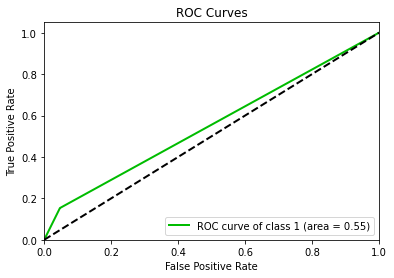

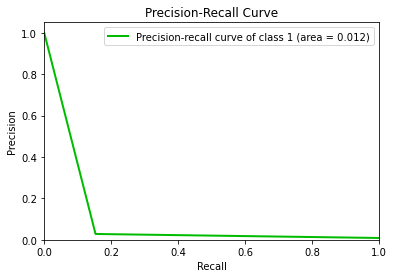

In [30]:
%time performances(classifier5, X_test, y_test,scale=True)

**Différences avec la même modèle sans BorderlineSMOTE :**


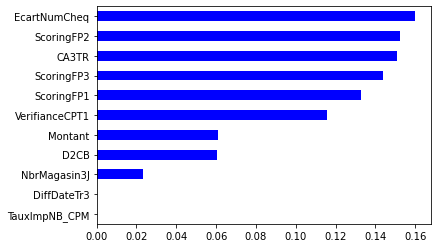

In [31]:
importances = pd.Series(modele.feature_importances_, index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()